In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Testing python's functionality

In [2]:
# Test to see if python will pass the same memory address
# Spoilers it does which is very nice :P

class SharedVariable():
    def __init__(self, value):
        self.value = value
class UserClass():
    created = 1
    def __init__(self, shared_variable):
        self.SharedVariable_class = shared_variable
        self.id = UserClass.created
        UserClass.created += 1
# Make the object to be passed        
passed_obj = SharedVariable('hello')

# Make the objects that get the class passed to
obj1 = UserClass(passed_obj)
obj2 = UserClass(passed_obj)
display(obj1.id)
display(obj2.id) 

# Check if changing it in one object will affect the other
display(obj1.SharedVariable_class.value)
obj1.SharedVariable_class.value = 'goodbye'
display(obj2.SharedVariable_class.value)

1

2

'hello'

'goodbye'

## Map class

In [3]:
# Read in raw data
path_to_data = os.path.join(os.getcwd(), "data\\SRTM_RAMP2_TOPO_2000-02-11_rgb_3600x1800.CSV")
raw_data = pd.read_csv(path_to_data, header=None).to_numpy()
n_emptyValues = sum(np.isnan(raw_data).flatten())
raw_data = raw_data[420:560, 730:920]

# Make sure the data doesn't have outliers
clip_mask = raw_data < np.percentile(raw_data, 1)
data = raw_data
data[clip_mask] = np.percentile(raw_data, 1)

# Squish data and scale it
data = np.log(data)
dMax = np.max(data)
dMin = np.min(data)
scaled_data = (data - dMin) / (dMax-dMin)
# scaled_data = (scaled_data - 1) * -1

# Compute gradient and how many empty values it has
derivative_data = np.gradient(raw_data)

<AxesSubplot:>

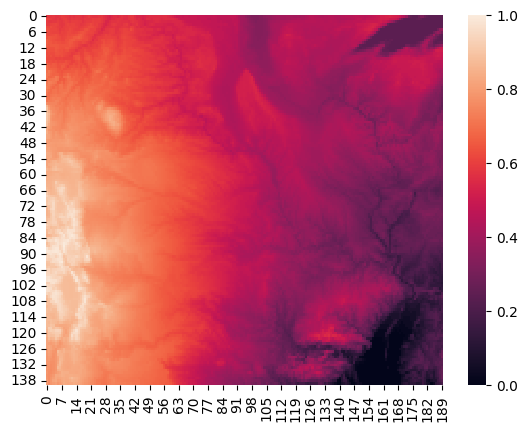

In [4]:
sns.heatmap(scaled_data)

In [6]:
class Map():
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.nNAN = 0
        self.data = self._data()
        self.gradientX, self.gradientY = self._gradient()
        
    def _data(self):           
        raw_data = pd.read_csv(path_to_data, header=None).to_numpy()
        self.nNAN = sum(np.isnan(raw_data).flatten())
        raw_data = raw_data[420:560, 730:920]

        # Make sure the data doesn't have outliers
        clip_mask = raw_data < np.percentile(raw_data, 1)
        data = raw_data
        data[clip_mask] = np.percentile(raw_data, 1)

        # Squish data and scale it
        data = np.log(data)
        dMax = np.max(data)
        dMin = np.min(data)
        
        return((data - dMin) / (dMax-dMin))

    def _gradient(self):
        # Compute gradient
        return(np.gradient(self.data))

In [7]:
mapData = Map(path_to_data)

## Cost class

In [8]:
class Cost():
    def __init__(self, a=1, b=1, c=-1):
        self.a = a
        self.b = b
        self.c = c
    def calculate_cost(self, gradient, current_height):
        return( self.a*np.abs(gradient) + self.b + self.c*current_height )

## Getting the surrounding pieces

In [86]:
def get_surrounding_values(position_vect, surrounding_map):
    # Works. Grabs a 1 pixel surrounding area
    # around a given position. If hits a boundry
    # Calls those values 0.
    posX, posY = position_vect # 168, 120
    xbounds = [0,surrounding_map.shape[1]]
    ybounds = [0,surrounding_map.shape[0]]
    
    borders =  [xbounds, ybounds]
    
    leftLimit = max((posX - 1), xbounds[0])
    rightLimit = min((posX + 1) + 1, xbounds[1]) # not inclusive like the min and left limits
    lowerLimit = max((posY - 1), ybounds[0])
    upperLimit = min((posY + 1) + 1, ybounds[1]) # not inclusive like the min and left limits
     
    limits = [leftLimit, rightLimit, lowerLimit, upperLimit]    
    excision = surrounding_map[lowerLimit:upperLimit, leftLimit:rightLimit]
    into_matrix = np.zeros([3,3])
    into_matrix[(lowerLimit - (posY - 1)): (upperLimit - (posY - 1)), 
                (leftLimit - (posX - 1)): (rightLimit - (posX - 1))] = excision
    
    into_matrix = into_matrix.flatten()
    into_matrix = np.delete(into_matrix, 4)
    
    # When we have the gradient values selected, we can dot with this
    # pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 4:[1,0], 5: [1,-1], 6: [0,-1], 7:[-1,-1], 8:[-1,0]}, index = ['x','y']).T
    #      1  2  3  4  5  6  7  8
    #   x -1  0  1  1  1  0 -1 -1
    #   y  1  1  1  0 -1 -1 -1  0
    
    return(into_matrix)

def check_out_of_bounds(proposed_position, bounds):
    check1 = proposed_position[0] > 0
    check2 = proposed_position[0] < bounds[1]
    check3 = proposed_position[1] > 0
    check4 = proposed_position[1] < bounds[0]
    checks = [check1, check2, check3, check4]
    # print(checks)
    if  check1 & check2 & check3 & check4:
        return False
    else:
        # print(f'out of bounds ({proposed_position[0]},{proposed_position[1]})')
        return True

In [69]:
check_out_of_bounds([139,189], [140,190])

True

In [94]:
# 8x2 of surrounding gradients
starting_point = [0,0]
thing1 = np.concatenate( [get_surrounding_values(starting_point, mapData.gradientY)[np.newaxis,:], 
                          get_surrounding_values(starting_point, mapData.gradientX)[np.newaxis,:]], 
                        axis=0 ).T
thing1

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.00292109,  0.02297167],
       [ 0.        ,  0.        ],
       [-0.00557707,  0.00288723],
       [-0.00846605,  0.        ]])

In [95]:
# 8x2
# thing2 = pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 
#                        4:[-1,0], 5: [1,0], 
#                        6: [-1,-1], 7:[0,-1], 8:[1,-1]}, index = ['x','y']).T.to_numpy()
thing2 = pd.DataFrame({1: [-1, -1], 2: [0,-1], 3: [1,-1], 
                       4:[-1,0], 5: [1,0], 
                       6: [-1,1], 7:[0,1], 8:[1,1]}, index = ['x','y']).T.to_numpy()
thing2 = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

In [96]:
thing3 = np.sum(thing1*thing2, axis=1)
# mask_thing3 = thing3 <= 0
# thing3[mask_thing3] = -1
thing3

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.00292109,
        0.        ,  0.00288723, -0.0059864 ])

Text(0.5, 1.0, 'Stored gradientX')

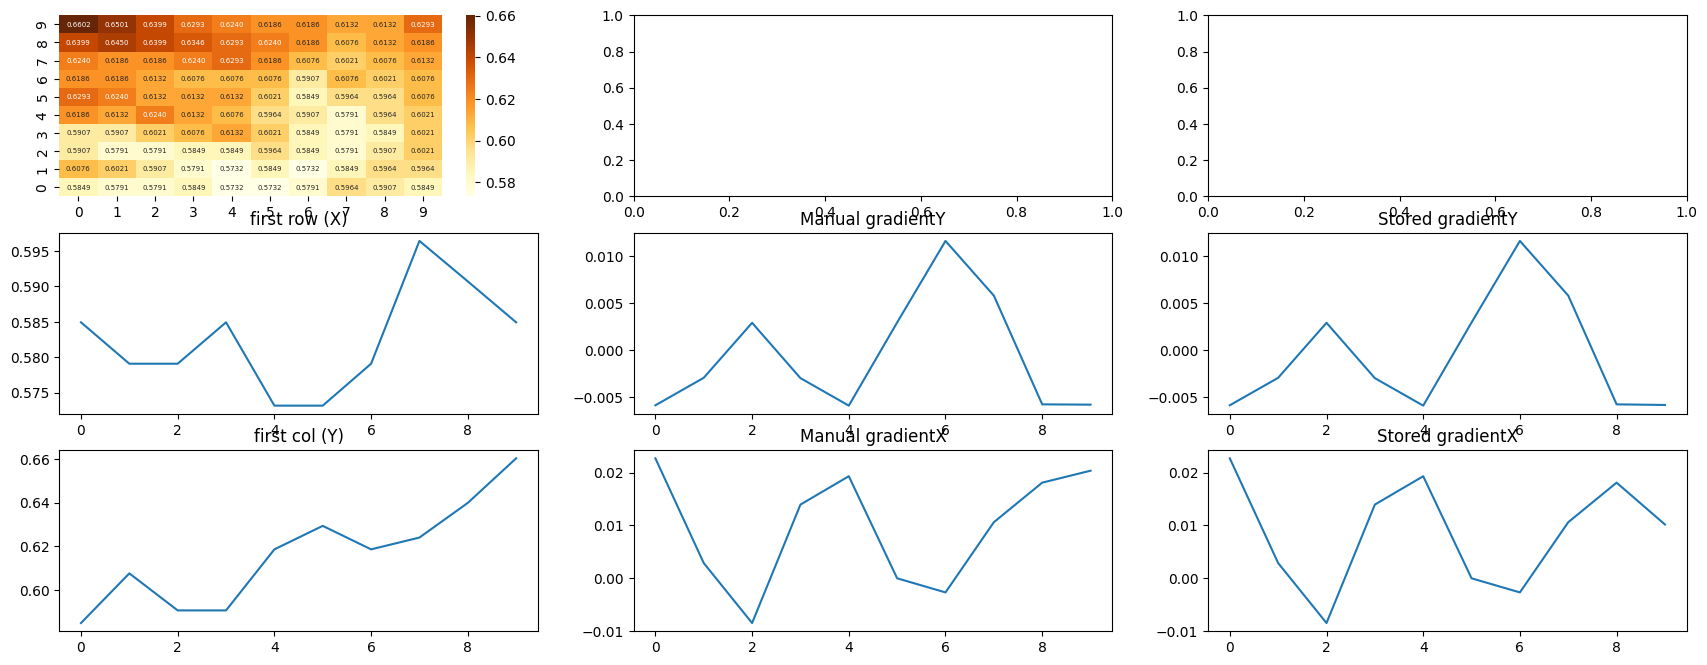

In [97]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(21,8))

sns.heatmap(mapData.data[0:10,0:10], cmap='YlOrBr', annot=True, fmt = '.4f', annot_kws = {"size": 5}, ax=axes[0,0])
axes[0,0].invert_yaxis()

axes[1,0].plot(mapData.data[0,0:10])
axes[1,0].set_title('first row (X)')
axes[1,1].plot(np.gradient(mapData.data[0,0:10]))
axes[1,1].set_title('Manual gradientY')
axes[1,2].plot(mapData.gradientY[0,0:10])
axes[1,2].set_title('Stored gradientY')

axes[2,0].plot(mapData.data[0:10,0])
axes[2,0].set_title('first col (Y)')
axes[2,1].plot(np.gradient(mapData.data[0:10,0]))
axes[2,1].set_title('Manual gradientX')
axes[2,2].plot(mapData.gradientX[0:10,0])
axes[2,2].set_title('Stored gradientX')

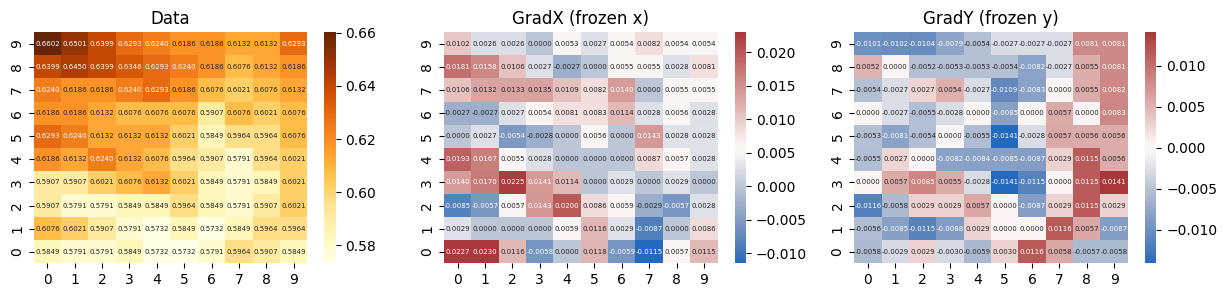

In [98]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,3))

sns.heatmap(mapData.data[0:10,0:10], ax = axes[0], cmap='YlOrBr', annot=True, fmt = '.4f', annot_kws = {"size": 5})
sns.heatmap(mapData.gradientX[0:10,0:10], ax = axes[1], cmap="vlag", annot=True, fmt = '.4f', annot_kws = {"size": 5})
sns.heatmap(mapData.gradientY[0:10,0:10], ax = axes[2], cmap="vlag", annot=True, fmt = '.4f', annot_kws = {"size": 5})
axes[0].set_title('Data')
axes[1].set_title('GradX (frozen x)')
axes[2].set_title('GradY (frozen y)')

for ax in axes:
    ax.invert_yaxis()

In [99]:
thing3

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.00292109,
        0.        ,  0.00288723, -0.0059864 ])

### Attempt a simple path walk

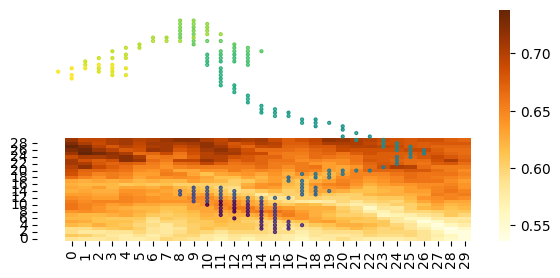

In [28]:
starting_point = np.array([10,10])
path_walked = [starting_point]
# 8x2 direction vectors
thing2 = pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 
                       4:[-1,0], 5: [1,0], 
                       6: [-1,-1], 7:[0,-1], 8:[1,-1]}, index = ['x','y']).T.to_numpy()
thing2_norm = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

for i in range(200):
    thing1 = np.concatenate( [get_surrounding_values(starting_point, mapData.gradientY)[np.newaxis,:], 
                              get_surrounding_values(starting_point, mapData.gradientX)[np.newaxis,:]], 
                            axis=0 ).T
    thing3 = np.sum(thing1*thing2_norm, axis=1)
    direction = thing2[np.argmax(thing3)]
    for i in range(2,9):
        # If we are going back on ourselves
        if np.any(np.all((starting_point + direction) == path_walked, axis=1)):
            direction = thing2[np.argsort(thing3, axis=0)[-i]]
        else:
            break
    starting_point = starting_point + direction
    path_walked.append(starting_point)

# Plotting the path
data1 = mapData.data[0:30,0:30]
data2 = np.array(path_walked)

f, ax = plt.subplots(figsize=(7, 3))
# plt.tick_params(bottom='on')
ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1)
ax.axis('tight')
ax.invert_yaxis()

plt.show()

### Attempt at bounded walk

1991 steps taken


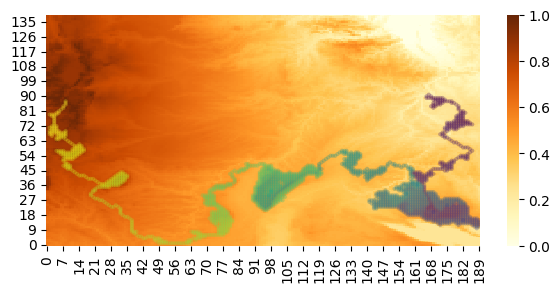

In [167]:
starting_point = np.array([168,90])# np.array([87,66]) # np.array([7,0])
path_walked = [starting_point]
# 8x2 direction vectors
thing2 = pd.DataFrame({1: [-1, -1], 2: [0,-1], 3: [1,-1], 
                       4:[-1,0], 5: [1,0], 
                       6: [-1,1], 7:[0,1], 8:[1,1]}, index = ['x','y']).T.to_numpy()
thing2_norm = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

for i in range(5000):
    # print(f"iter-{i} --- {starting_point} --- {check_out_of_bounds((starting_point), mapData.data.shape)}")
    thing1 = np.concatenate( [get_surrounding_values(starting_point, mapData.gradientY)[np.newaxis,:], 
                              get_surrounding_values(starting_point, mapData.gradientX)[np.newaxis,:]], 
                            axis=0 ).T
    thing3 = np.sum(thing1*thing2_norm, axis=1)
    direction = thing2[np.argmax(thing3)]
    for j in range(2,9):
        # If we are going back on ourselves or going out of bounds
        # try a different direction
        if np.any(np.all((starting_point + direction) == path_walked, axis=1)) | check_out_of_bounds((starting_point + direction), mapData.data.shape):
            direction = thing2[np.argsort(thing3, axis=0)[-j]]
        else:
            break
    starting_point = starting_point + direction
    path_walked.append(starting_point)
    if mapData.data[starting_point[1], starting_point[0]] == np.max(mapData.data):
        print(f'{i} steps taken')
        break

# Plotting the path
data1 = mapData.data[0:200,0:200]
data2 = np.array(path_walked)

f, ax = plt.subplots(figsize=(7, 3))
# plt.tick_params(bottom='on')
ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1, alpha = 0.3)
ax.axis('tight')
ax.invert_yaxis()

plt.show()

## Making the neural net
- We need a layer class that can perform the forward pass
- We need an activation function (ReLu) each node can experience
- We need the final output layer and the softmax activation function
- Ultimately we need a method to return trainable weights that we can choose from and edit
- We need a way to randomly initiate all trainable weights